In [2]:
import numpy as np
import itertools
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#Robot Abstraction class

In [3]:

class RobotAbstraction2D:
    """Abstraction symbolique du robot."""
    def __init__(self, state_intervals, control_values, perturbation, delta_t):
        self.state_intervals = state_intervals  # [(x_min, x_max), (y_min, y_max)]
        self.control_values = control_values  # [(vx_min, vx_max), (vy_min, vy_max)]
        self.perturbation = perturbation  # [(w1_min, w1_max), (w2_min, w2_max)]
        self.delta_t = delta_t  # sampling time = 1s
        self.state_to_index = {"OutOfGrid": -1}
        self.index_to_intervals = {}
        self.state_edges = []
        self.discrete_x_y = 50  
        self.vx_vals = 5
        self.vy_vals = 5
        self._create_state_mapping()

    def _create_state_mapping(self):
        """Crée la discrétisation de l'espace d'état."""
        self.state_edges = [
            np.linspace(interval[0], interval[1], self.discrete_x_y) for interval in self.state_intervals
        ]

        state_grid = np.array(np.meshgrid(*[edges[:-1] for edges in self.state_edges])).T.reshape(-1, 2)

        for idx, state in enumerate(state_grid, start=1):
            discrete_state = tuple(
                np.digitize(state[i], self.state_edges[i]) for i in range(len(state))
            )
            self.state_to_index[discrete_state] = idx

            intervals = []
            for i, edge in enumerate(self.state_edges):
                low = edge[discrete_state[i] - 1]
                high = edge[discrete_state[i]]
                intervals.append((low, high))
            self.index_to_intervals[idx] = intervals

    def dynamics(self, x_center, u, w_center, D_x, D_w):
        """Dynamique continue avec perturbation."""
        nominal_dynamics = np.array([
            x_center[0] + self.delta_t * (u[0] + w_center[0]),
            x_center[1] + self.delta_t * (u[1] + w_center[1])
        ])
        delta_x = np.array([
            (self.state_intervals[0][1] - self.state_intervals[0][0]) / (self.discrete_x_y - 1),
            (self.state_intervals[1][1] - self.state_intervals[1][0]) / (self.discrete_x_y - 1)
        ])
        delta_w = np.array([
            (self.perturbation[0][1] - self.perturbation[0][0]) / 2,
            (self.perturbation[1][1] - self.perturbation[1][0]) / 2
        ])

        correction = (
            nominal_dynamics - D_x @ delta_x - D_w @ delta_w,
            nominal_dynamics + D_x @ delta_x + D_w @ delta_w
        )
        return correction

    def compute_Dx_and_Dw(self, u):
        D_x = np.array([[1, 0], [0, 1]])
        D_w = np.array([[self.delta_t, 0], [0, self.delta_t]])
        return D_x, D_w

    def _find_state(self, x):
        discrete_state = tuple(
            min(np.digitize(x[i], self.state_edges[i]), len(self.state_edges[i]) - 1)
            for i in range(len(x))
        )
        return self.state_to_index.get(discrete_state, -1)

    def compute_transitions_safe(self):
        """
        Construit la relation de transition g : Ξ × Σ → 2^Ξ .
        Renvoie une liste de triplets (ξ, σ, Succ(ξ,σ)).
        """
        transitions = []
        x_edges = self.state_edges[0]
        y_edges = self.state_edges[1]
        n_x = len(x_edges) - 1
        n_y = len(y_edges) - 1

        x_centers = (x_edges[:-1] + x_edges[1:]) / 2
        y_centers = (y_edges[:-1] + y_edges[1:]) / 2

        state_grid_indexed = []
        for i, x_c in enumerate(x_centers):
            for j, y_c in enumerate(y_centers):
                state_id = i * n_y + j + 1
                state_grid_indexed.append((x_c, y_c, state_id))

        vx_vals = np.linspace(self.control_values[0][0], self.control_values[0][1], self.vx_vals)
        vy_vals = np.linspace(self.control_values[1][0], self.control_values[1][1], self.vy_vals)
        control_grid = [(vx, vy) for vx in vx_vals for vy in vy_vals]

        delta_x_val = (self.state_intervals[0][1] - self.state_intervals[0][0]) / (self.discrete_x_y - 1)
        delta_y_val = (self.state_intervals[1][1] - self.state_intervals[1][0]) / (self.discrete_x_y - 1)
        delta_wx = (self.perturbation[0][1] - self.perturbation[0][0]) / 2
        delta_wy = (self.perturbation[1][1] - self.perturbation[1][0]) / 2

        out_of_bounds_count = 0

        for x_c, y_c, state_id in state_grid_indexed:
            x_center = np.array([x_c, y_c])
            w_center = np.zeros(2)

            for control in control_grid:
                u = np.array(control)
                x_next_nom = x_center + self.delta_t * u

                dx = np.array([delta_x_val, delta_y_val])
                dw = np.array([delta_wx, delta_wy])

                x_next_lower = x_next_nom - dx - self.delta_t * dw
                x_next_upper = x_next_nom + dx + self.delta_t * dw

                x_next_lower[0] = max(x_next_lower[0], self.state_intervals[0][0])
                x_next_lower[1] = max(x_next_lower[1], self.state_intervals[1][0])
                x_next_upper[0] = min(x_next_upper[0], self.state_intervals[0][1])
                x_next_upper[1] = min(x_next_upper[1], self.state_intervals[1][1])

                i_min = np.searchsorted(x_edges, x_next_lower[0], side='right') - 1
                i_max = np.searchsorted(x_edges, x_next_upper[0], side='left') - 1
                j_min = np.searchsorted(y_edges, x_next_lower[1], side='right') - 1
                j_max = np.searchsorted(y_edges, x_next_upper[1], side='left') - 1

                i_min = max(0, min(i_min, n_x - 1))
                i_max = max(0, min(i_max, n_x - 1))
                j_min = max(0, min(j_min, n_y - 1))
                j_max = max(0, min(j_max, n_y - 1))

                successors = set()
                for i in range(i_min, i_max + 1):
                    for j in range(j_min, j_max + 1):
                        succ_id = i * n_y + j + 1
                        successors.add(succ_id)

                if successors:
                    transitions.append((state_id, tuple(control), successors))
                else:
                    out_of_bounds_count += 1

        print(f"Transition computation: {len(transitions)} valid transitions, {out_of_bounds_count} OOB rejected")
        return transitions

    def find_indices_for_interval(self, interval):
        overlapping_indices = []
        for index, intervals in self.index_to_intervals.items():
            overlap = True
            for dim in range(len(interval)):
                if not (interval[dim][1] >= intervals[dim][0] and interval[dim][0] <= intervals[dim][1]):
                    overlap = False
                    break
            if overlap:
                overlapping_indices.append(index)
        return overlapping_indices

    def plot_grid_and_regions(self, regions_dict=None, title="Grid and Regions"):
        fig, ax = plt.subplots(figsize=(8, 8))
        for i, edges in enumerate(self.state_edges):
            if i == 0:
                for edge in edges:
                    ax.axvline(edge, color='gray', linestyle='--', linewidth=0.5)
            else:
                for edge in edges:
                    ax.axhline(edge, color='gray', linestyle='--', linewidth=0.5)

        if regions_dict:
            region_info = {
                'R1': {'color': 'lightblue', 'desc': 'R1'},
                'R2': {'color': 'lightgreen', 'desc': 'R2'},
                'R3': {'color': 'orange', 'desc': 'R3'},
                'R4': {'color': 'red', 'desc': 'R4 '}
            }
            for name, region in regions_dict.items():
                info = region_info.get(name, {'color': 'gray', 'desc': name})
                rect = patches.Rectangle(
                    (region[0][0], region[1][0]),
                    region[0][1] - region[0][0],
                    region[1][1] - region[1][0],
                    linewidth=2,
                    edgecolor=info['color'],
                    facecolor=info['color'],
                    alpha=0.3,
                    label=info['desc']
                )
                ax.add_patch(rect)
                cx = region[0][0] + (region[0][1] - region[0][0]) / 2
                cy = region[1][0] + (region[1][1] - region[1][0]) / 2
                ax.text(cx, cy, name, color='black', fontsize=12,
                        ha='center', va='center', fontweight='bold')

        ax.set_xlim(self.state_intervals[0])
        ax.set_ylim(self.state_intervals[1])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        if regions_dict:
            ax.legend()
        plt.tight_layout()
        plt.show()

In [4]:
class SymbolicControllerSynthesis:
    def __init__(self, transitions, state_space):
        self.transitions = self._process_transitions(transitions)
        self.state_space = state_space

    def _process_transitions(self, transitions):
        transition_dict = defaultdict(set)
        for state, control, successors in transitions:
            transition_dict[(state, control)] = successors
        return dict(transition_dict)

    def pre(self, R):
       
        pre_states = set()
        for (state, control), successors in self.transitions.items():
            if successors.issubset(R):
                pre_states.add(state)
        return pre_states

    #  ALGORITHME 2  DOMAINE D'ATTEIGNABILITÉ
    def compute_reachability_domain(self, Q_a):
        R_k = Q_a.copy()
        iteration = 0
        while True:
            iteration += 1
            R_k_plus_1 = Q_a.union(self.pre(R_k))
            if R_k_plus_1 == R_k:
                break
            R_k = R_k_plus_1
        print(f"  Atteignabilité : convergé en {iteration} itérations, |R*| = {len(R_k)}")
        return R_k

    #  ALGORITHME 1  : DOMAINE DE SÛRETÉ
    def compute_safety_domain(self, Q_s):
        R_k = Q_s.copy()
        iteration = 0
        while True:
            iteration += 1
            R_k_plus_1 = Q_s.intersection(self.pre(R_k))
            if R_k_plus_1 == R_k:
                break
            R_k = R_k_plus_1
        print(f"  Sûreté : convergé en {iteration} itérations, |R*| = {len(R_k)}")
        return R_k

    # THÉORÈME 2 & 4 : SYNTHÈSE DU CONTRÔLEUR
    def synthesize_controller(self, R_star):
        controller = defaultdict(set)
        Q_0 = set()
        for (state, control), successors in self.transitions.items():
            if state in R_star and successors and successors.issubset(R_star):
                controller[state].add(control)
        for state in R_star:
            if controller[state]:
                Q_0.add(state)
        return dict(controller), Q_0
    

In [5]:
class AutomatonObjective2:
    def __init__(self):
       
            self.states = {'a', 'b', 'c', 'd', 'e'}
            self.initial = 'a'
            self.accepting = {'d'}
            self.transitions = {
                'a': {'0': 'a', '1': 'b', '2': 'c', '3': 'a', '4': 'e'},
                'b': {'0': 'b', '1': 'b', '2': 'e', '3': 'd', '4': 'e'},
                'c': {'0': 'c', '1': 'e', '2': 'c', '3': 'd', '4': 'e'},
                'e': {'0': 'e', '1': 'e', '2': 'e', '3': 'e', '4': 'e'},
                'd': {'0': 'd', '1': 'd', '2': 'd', '3': 'd', '4': 'd'}
            }
    
    def next_state(self, current_state, label):
        return self.transitions[current_state].get(label, None)

    def is_accepting(self, state):
        return state in self.accepting



In [6]:
class AutomatonObjective3:
    def __init__(self):
        self.states = {'s0', 's1', 's2', 's3', 's4', 'trap'}
        self.initial = 's0'
        self.accepting = {'s4'}
        self.transitions = {
            's0': {'0': 's0', '1': 's1', '2': 'trap', '3': 'trap', '4': 'trap'},
            's1': {'0': 's1', '1': 's1', '2': 's2', '3': 'trap', '4': 'trap'},
            's2': {'0': 's2', '2': 's2', '3': 's3', '1': 'trap', '4': 'trap'},
            's3': {'0': 's3', '3': 's3', '4': 's4', '1': 'trap', '2': 'trap'},
            's4': {'0': 's4', '1': 's4', '2': 's4', '3': 's4', '4': 's4'},
            'trap': {'0': 'trap', '1': 'trap', '2': 'trap', '3': 'trap', '4': 'trap'}
        }

    def next_state(self, current_state, label):
        return self.transitions[current_state].get(label, 'trap')

    def is_accepting(self, state):
        return state in self.accepting

In [7]:
# OBJECTIF 3 & 4 : SYNTHÈSE AUTOMATE 
class AutomatonBasedControllerSynthesis:
    def __init__(self, transitions, automaton, R1_indices, R2_indices, R3_indices, R4_indices, robot):
        self.transitions = transitions
        self.automaton = automaton
        self.R1_indices = R1_indices
        self.R2_indices = R2_indices
        self.R3_indices = R3_indices
        self.R4_indices = R4_indices
        self.robot = robot
        self.transition_dict = self._build_transition_dict(transitions)
        self.state_space = set(state_id for (state_id, control, successors) in transitions if state_id != -1)

    def _build_transition_dict(self, transitions):
        td = defaultdict(set)
        for state, control, successors in transitions:
            if state != -1:
                td[(state, control)] = successors
        return dict(td)

    def _get_label(self, state_idx):
        return get_region_label(state_idx, self.R1_indices, self.R2_indices, self.R3_indices, self.R4_indices)

    def synthesize_dynamic_controller(self):
        L = self._get_label
        product_states = [(x, q) for x in self.state_space for q in self.automaton.states]
        print(f"[Synth] Produit |Ξ×Ψ| = {len(self.state_space)} × {len(self.automaton.states)} = {len(product_states)}")

        target = {(x, q) for (x, q) in product_states if q in self.automaton.accepting}
        W = target.copy()
        iteration = 0
        changed = True

        while changed:
            iteration += 1
            new_pre = set()

            for (x, q) in product_states:
                if (x, q) in W:
                    continue

                for u in {u for (s, u) in self.transition_dict.keys() if s == x}:
                    successors = self.transition_dict.get((x, u), set())
                    if not successors:
                        continue

                    all_covered = True
                    for x_next in successors:
                        label = L(x_next)
                        q_next = self.automaton.next_state(q, label)
                        if q_next is None or (x_next, q_next) not in W:
                            all_covered = False
                            break

                    if all_covered:
                        new_pre.add((x, q))
                        break

            if new_pre:
                W |= new_pre
                if iteration % 10 == 0:
                    print(f"  Iter {iteration:2d}: |W| = {len(W)}")
            else:
                changed = False

        print(f"[Synth] Convergé en {iteration} itérations. |W*| = {len(W)}")

        controller = defaultdict(set)
        Q0 = set()
        for (x, q) in W:
            if q == self.automaton.initial:
                Q0.add(x)
            for u in {u for (s, u) in self.transition_dict.keys() if s == x}:
                successors = self.transition_dict.get((x, u), set())
                if not successors:
                    continue
                all_covered = True
                for x_next in successors:
                    label = L(x_next)
                    q_next = self.automaton.next_state(q, label)
                    if q_next is None or (x_next, q_next) not in W:
                        all_covered = False
                        break
                if all_covered:
                    controller[(x, q)].add(u)

        print(f"[Synth] Contrôleur: {len(controller)} paires, |Q₀| = {len(Q0)}")
        return dict(controller), Q0
    def execute_controller_objective2(self, start_sym_state, controller, R3, max_steps=300):
        """Original execution for Objective 2 (◊(R1∨R2) ∧ ◊R3 ∧ □¬R4)."""
        if start_sym_state not in {x for (x, q) in controller.keys() if q == self.automaton.initial}:
            print(f" État initial {start_sym_state} ∉ Q₀")
            return None, None

        intervals_start = self.robot.index_to_intervals[start_sym_state]
        x_cont = np.array([
            (intervals_start[0][0] + intervals_start[0][1]) / 2,
            (intervals_start[1][0] + intervals_start[1][1]) / 2
        ])
        x = start_sym_state
        q = self.automaton.initial
        steps = 0

        path = []
        trajectory = [x_cont.copy()]

        r1_center = np.array([(4+5)/2, (8.5+9.5)/2])
        r2_center = np.array([(8.5+9.5)/2, (2+3)/2])
        r3_center = np.array([(2+3)/2, (0.5+1.5)/2])

        while steps < max_steps:
            #  Vérification CONTINUE de R2 (pas seulement symbolique)
            if (R3[0][0] <= x_cont[0] <= R3[0][1] and R3[1][0] <= x_cont[1] <= R3[1][1]):
                if q == 'b' or q == 'c':
                    q = 'd'
                    print(f" R3 atteint (continu) en {steps} étapes")
                    path.append((x_cont.copy(), x, q, None))
                    trajectory.append(x_cont.copy())
                    return path, trajectory

            if q == 'd':
                path.append((x_cont.copy(), x, q, None))
                trajectory.append(x_cont.copy())
                return path, trajectory

            available = controller.get((x, q), set())
            if not available:
                return None, None

            # Politique optimale (phase 1 → phase 2)
            if q == 'a':
                def score(u):
                    s = next(iter(self.transition_dict.get((x, u), {x})))
                    c = np.mean(self.robot.index_to_intervals[s], axis=1)
                    l = self._get_label(s)
                    if l == '1': return np.linalg.norm(c - r1_center) - 10
                    if l == '2': return np.linalg.norm(c - r2_center) - 10
                    if l == '3': return float('inf')
                    return min(np.linalg.norm(c - r1_center), np.linalg.norm(c - r2_center))
                u = min(available, key=score, default=next(iter(available)))
            else:
                def score(u):
                    s = next(iter(self.transition_dict.get((x, u), {x})))
                    c = np.mean(self.robot.index_to_intervals[s], axis=1)
                    return np.linalg.norm(c - r3_center)
                u = min(available, key=score, default=next(iter(available)))

            # Continuous dynamic
            D_x, D_w = self.robot.compute_Dx_and_Dw(u)
            lower, upper = self.robot.dynamics(x_cont, u, np.zeros(2), D_x, D_w)
            x_next_cont = (lower + upper) / 2
            x_next_cont = np.clip(x_next_cont, [0, 0], [10, 10])
            x_next_sym = self.robot._find_state(x_next_cont)

            if x_next_sym == -1:
                return None, None

            label = self._get_label(x_next_sym)
            q_next = self.automaton.next_state(q, label)
            if q_next is None:
                return None, None

            path.append((x_cont.copy(), x, q, u))
            trajectory.append(x_next_cont.copy())

            x_cont, x, q = x_next_cont, x_next_sym, q_next
            steps += 1

        return path, trajectory
    #  Execution for Objective 3 (strict sequence)
    def execute_controller_objective3(self, start_sym_state, controller, target_region, max_steps=500):
        if start_sym_state not in {x for (x, q) in controller.keys() if q == self.automaton.initial}:
            print(f" État initial {start_sym_state} ∉ Q₀")
            return None, None

        intervals_start = self.robot.index_to_intervals[start_sym_state]
        x_cont = np.array([
            (intervals_start[0][0] + intervals_start[0][1]) / 2,
            (intervals_start[1][0] + intervals_start[1][1]) / 2
        ])
        x = start_sym_state
        q = self.automaton.initial
        steps = 0

        path = []
        trajectory = [x_cont.copy()]

        # Region centroids for heuristic
        centers = {
            '1': np.array([(4+5)/2, (8.5+9.5)/2]),
            '2': np.array([(8.5+9.5)/2, (2+3)/2]),
            '3': np.array([(2+3)/2, (0.5+1.5)/2]),
            '4': np.array([(3+7)/2, (3+7)/2])  # R4 center
        }

        while steps < max_steps:
            # Continuous check for final region R4 and automaton state s4
            if (target_region[0][0] <= x_cont[0] <= target_region[0][1] and 
                target_region[1][0] <= x_cont[1] <= target_region[1][1]):
                if q == 's4':
                    print(f" Objectif 4 accompli en {steps} étapes (R4 atteint)")
                    path.append((x_cont.copy(), x, q, None))
                    trajectory.append(x_cont.copy())
                    return path, trajectory

            if q == 's4':
                print(f" Automaton reached s4 at step {steps} (symbolic success)")
                path.append((x_cont.copy(), x, q, None))
                trajectory.append(x_cont.copy())
                return path, trajectory

            available = controller.get((x, q), set())
            if not available:
                print(f" No control at (x={x}, q={q}) — dead end")
                return None, None

            # Determine next target label based on current automaton state
            next_target_map = {'s0': '1', 's1': '2', 's2': '3', 's3': '4'}
            next_target = next_target_map.get(q, '4')

            # Heuristic scoring: encourage progress, penalize wrong regions
            def score(u):
                succ_set = self.transition_dict.get((x, u), {x})
                # Use first successor for estimation (consistent with your original)
                s = next(iter(succ_set))
                c = np.mean(self.robot.index_to_intervals[s], axis=1)
                label = self._get_label(s)
                dist = np.linalg.norm(c - centers.get(next_target, centers['4']))
                if label == next_target:
                    return dist - 10.0  # strong incentive
                if label in ['0', next_target]:  # neutral or progress
                    return dist
                return float('inf')  # illegal region

            try:
                u = min(available, key=score)
            except:
                u = next(iter(available))

            # Continuous dynamics
            D_x, D_w = self.robot.compute_Dx_and_Dw(u)
            lower, upper = self.robot.dynamics(x_cont, u, np.zeros(2), D_x, D_w)
            x_next_cont = (lower + upper) / 2
            x_next_cont = np.clip(x_next_cont, [0, 0], [10, 10])
            x_next_sym = self.robot._find_state(x_next_cont)

            if x_next_sym == -1:
                print(" Out of grid")
                return None, None

            label = self._get_label(x_next_sym)
            q_next = self.automaton.next_state(q, label)
            if q_next == 'trap':
                print(f" Trapped (label={label} in state {q}) at step {steps}")
                return None, None

            path.append((x_cont.copy(), x, q, u))
            trajectory.append(x_next_cont.copy())

            x_cont, x, q = x_next_cont, x_next_sym, q_next
            steps += 1

        print(" Max steps reached without completion")
        return path, trajectory




In [8]:

def get_region_label(state_idx, R1_indices, R2_indices, R3_indices, R4_indices):
    if state_idx in R4_indices:
        return '4'
    elif state_idx in R3_indices:
        return '3'
    elif state_idx in R2_indices:
        return '2'
    elif state_idx in R1_indices:
        return '1'
    else:
        return '0'
    

def generate_safe_trajectory_direct_to_goal(
    x0, w0, controller_concretized, robot, 
    max_steps=200, avoid_regions=None, goal_region=None, goal_center=None
):
    """
    Execute safety controller (Obj 2) with explicit goal (R3).
    Combines □¬R4 (safety) with ◊R3 (reachability) in one run.
    """
    if avoid_regions is None:
        avoid_regions = []
    if goal_region is None:
        raise ValueError("goal_region must be specified for Objective 2 execution")

    x_cont = x0.copy()
    trajectory = [x_cont.copy()]
    steps = 0

    # Precompute goal center if not provided
    if goal_center is None:
        goal_center = np.array([
            (goal_region[0][0] + goal_region[0][1]) / 2,
            (goal_region[1][0] + goal_region[1][1]) / 2
        ])

    def in_region(pos, region):
        return (region[0][0] <= pos[0] <= region[0][1] and 
                region[1][0] <= pos[1] <= region[1][1])

    def in_any_forbidden(pos):
        return any(in_region(pos, reg) for reg in avoid_regions)

    print(f"[Obj2] Starting at ({x0[0]:.2f}, {x0[1]:.2f})")

    while steps < max_steps:
        # Check goal (R3) — continuous
        if in_region(x_cont, goal_region):
            print(f" Objective 2 SUCCESS: Reached R3 at step {steps}")
            return trajectory

        #  Safety check — continuous
        if in_any_forbidden(x_cont):
            print(f" Objective 2 FAILED: Entered forbidden region at step {steps}")
            return None

        # Find current symbolic state
        x_sym = robot._find_state(x_cont)
        if x_sym == -1:
            print(f" Out of grid at step {steps}")
            return None

        # Get available controls
        if x_sym not in controller_concretized:
            print(f"No control for state {x_sym}")
            return None

        _, available_controls = controller_concretized[x_sym]

        if not available_controls:
            print(f" No safe controls at state {x_sym}")
            return None

        # Heuristic: prefer controls that move toward goal (without violating safety)
        best_u = None
        best_score = float('inf')

        for u in available_controls:
            # Predict next position
            D_x, D_w = robot.compute_Dx_and_Dw(u)
            lower, upper = robot.dynamics(x_cont, u, w0, D_x, D_w)
            x_next = (lower + upper) / 2
            x_next = np.clip(x_next, [0, 0], [10, 10])

            # Reject if unsafe
            if in_any_forbidden(x_next):
                continue

            # Score by distance to goal
            dist = np.linalg.norm(x_next - goal_center)
            if dist < best_score:
                best_score = dist
                best_u = u

        if best_u is None:
            # Fallback: try stopping
            best_u = (0.0, 0.0)
            D_x, D_w = robot.compute_Dx_and_Dw(best_u)
            _, upper = robot.dynamics(x_cont, best_u, w0, D_x, D_w)
            x_next = (x_cont + upper) / 2
            if in_any_forbidden(x_next):
                print(f" Even stopping leads to violation at step {steps}")
                return None

        # Apply control
        D_x, D_w = robot.compute_Dx_and_Dw(best_u)
        lower, upper = robot.dynamics(x_cont, best_u, w0, D_x, D_w)
        x_cont = (lower + upper) / 2
        x_cont = np.clip(x_cont, [0, 0], [10, 10])
        trajectory.append(x_cont.copy())
        steps += 1

        if steps % 50 == 0:
            print(f"  Step {steps}: pos=({x_cont[0]:.2f}, {x_cont[1]:.2f})")

    print(f" Max steps ({max_steps}) reached without reaching goal")
    return trajectory

# ===== FONCTIONS UTILITAIRES =====
def select_initial_state_from_Q0_safe(Q_0, robot, avoid_indices=None):
    Q_0_clean = Q_0 - {-1}
    if avoid_indices:
        Q_0_clean = Q_0_clean - avoid_indices
    if not Q_0_clean:
        raise ValueError("Aucun état initial valide dans Q₀ !")
    s0 = random.choice(list(Q_0_clean))
    iv = robot.index_to_intervals[s0]
    x0 = np.array([(iv[0][0]+iv[0][1])/2, (iv[1][0]+iv[1][1])/2])
    print(f"État initial : ξ={s0}, x₀=({x0[0]:.3f}, {x0[1]:.3f})")
    return x0, s0

def plot_trajectory(trajectory, regions_dict=None, title="Trajectoire"):
    fig, ax = plt.subplots(figsize=(8, 8))
    traj = np.array(trajectory)
    ax.plot(traj[:, 0], traj[:, 1], 'b-', linewidth=2, alpha=0.8, label='Trajectoire')
    ax.plot(traj[0, 0], traj[0, 1], 'go', markersize=10, label='Départ')
    ax.plot(traj[-1, 0], traj[-1, 1], 'ro', markersize=10, label='Arrivée')

    if regions_dict:
        colors = {'R1': 'lightblue', 'R2': 'lightgreen', 'R3': 'orange', 'R4': 'red'}
        for name, R in regions_dict.items():
            rect = patches.Rectangle(
                (R[0][0], R[1][0]), R[0][1]-R[0][0], R[1][1]-R[1][0],
                linewidth=2, edgecolor=colors[name], facecolor=colors[name], alpha=0.3
            )
            ax.add_patch(rect)
            ax.text(R[0][0]+(R[0][1]-R[0][0])/2, R[1][0]+(R[1][1]-R[1][0])/2, name,
                    ha='center', va='center', fontweight='bold')

    ax.set(xlim=(0,10), ylim=(0,10), xlabel='X', ylabel='Y', title=title)
    ax.grid(True, alpha=0.3); ax.legend(); plt.tight_layout(); plt.show()



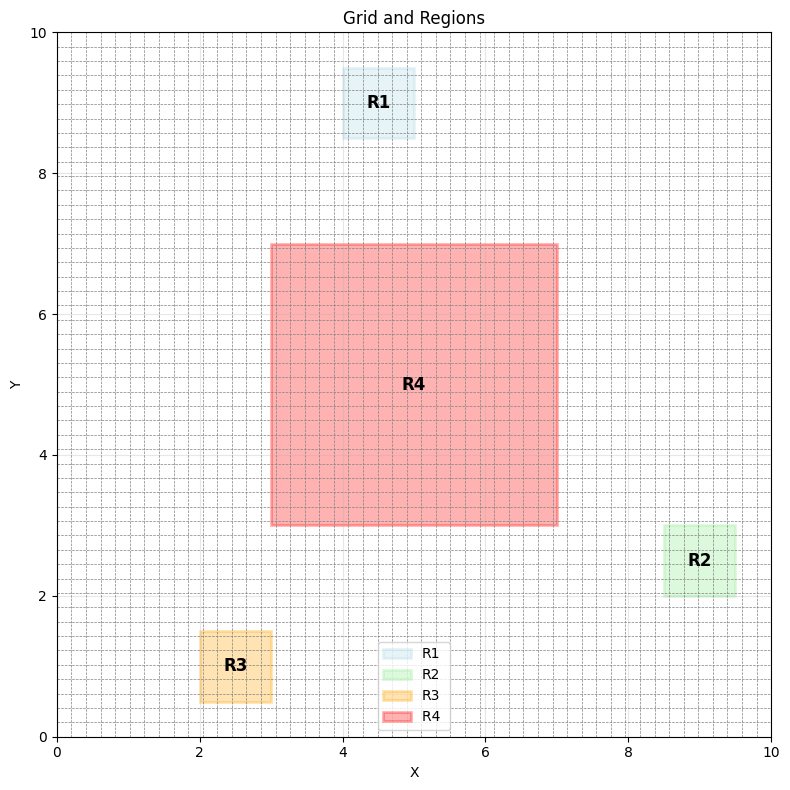


RSymbolic Coverage :
  R1: 36, R2: 36, R3: 36, R4: 441
Transition computation: 60025 valid transitions, 0 OOB rejected

=== OBJECTIVE 1  : Safety — Avoid R4 and Reachability — reach R3===
  Sûreté : convergé en 1 itérations, |R*| = 1960

=== OBJECTIVE 2 : Temporal Mission ===
[Synth] Produit |Ξ×Ψ| = 2401 × 5 = 12005
  Iter 10: |W| = 8875
[Synth] Convergé en 14 itérations. |W*| = 9361
[Synth] Contrôleur: 9361 paires, |Q₀| = 2320

=== OBJECTIF 3 : Enchaînement strict R1 → R2 → R3 → R4 ===
[Synth] Produit |Ξ×Ψ| = 2401 × 6 = 14406
  Iter 10: |W| = 7473
  Iter 20: |W| = 11022
[Synth] Convergé en 24 itérations. |W*| = 11762
[Synth] Contrôleur: 11762 paires, |Q₀| = 2320
État initial : ξ=1317, x₀=(5.408, 8.673)
[Obj2] Starting at (5.41, 8.67)
No control for state 1317
[Obj2] Starting at (5.41, 8.67)
No control for state 1317
[Obj2] Starting at (5.41, 8.67)
No control for state 1317
[Obj2] Starting at (5.41, 8.67)
No control for state 1317
[Obj2] Starting at (5.41, 8.67)
No control for state 1

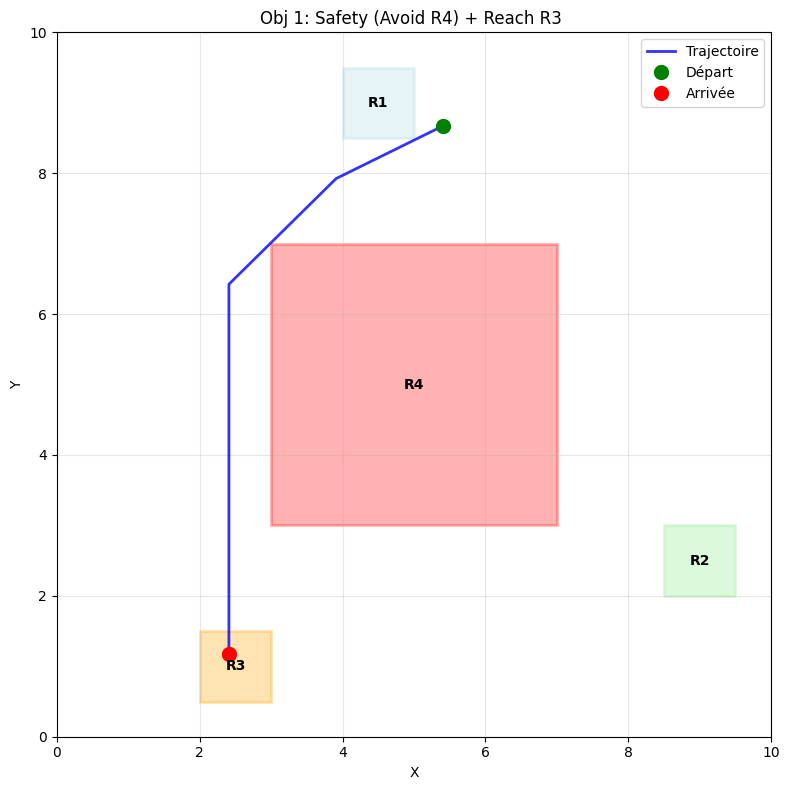


 Objective 2 (◊(R1∨R2) ∧ ◊R3 ∧ □¬R4):


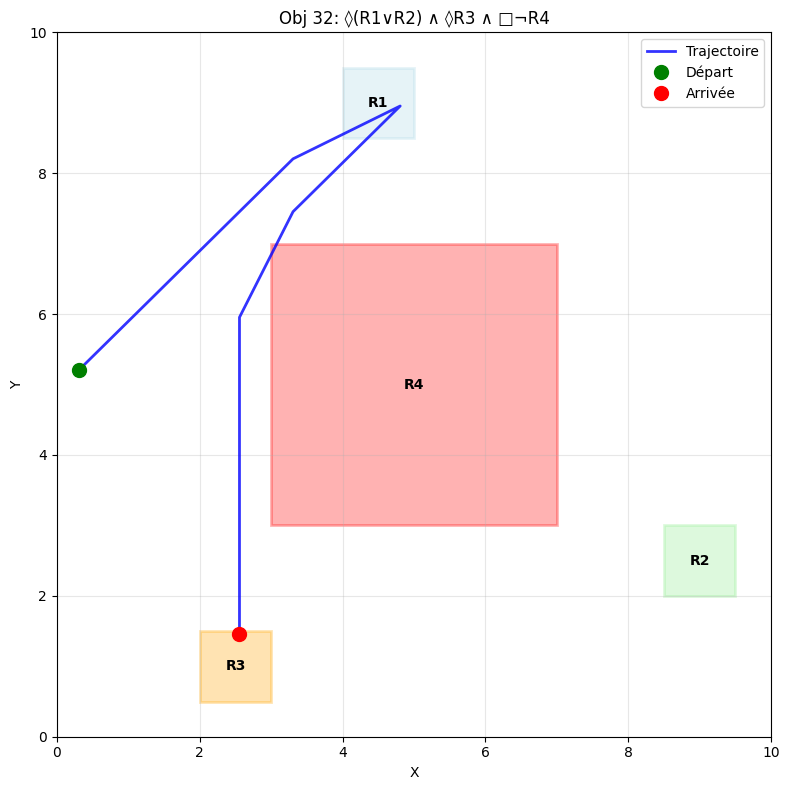


Objective 3 (R1 → R2 → R3 → R4):
  Trial 1: start ξ=8
 Objectif 4 accompli en 16 étapes (R4 atteint)


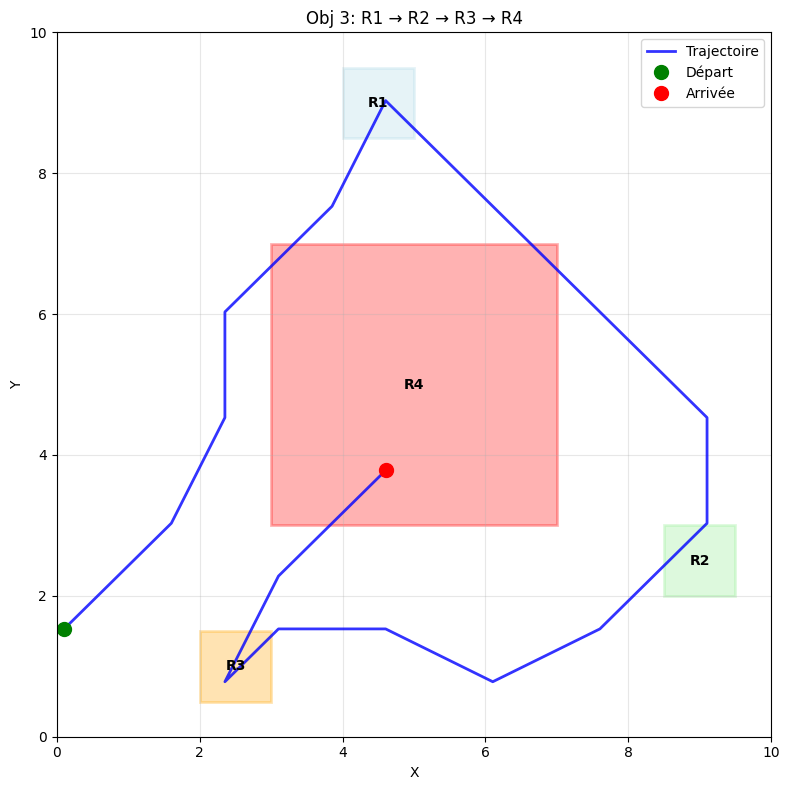

    Phases: s0 → ... → s4

 Tous les objectifs (1–4) sont implémenté


In [9]:

# ===== EXECUTION PRINCIPALE =====
if __name__ == "__main__":
    # System Parameters
    state_intervals = [(0, 10), (0, 10)]
    perturbation = [(-0.02, 0.02), (-0.02, 0.02)]
    control_values = [(-1.5, 1.5), (-1.5, 1.5)]
    delta_t = 1

    robot = RobotAbstraction2D(state_intervals, control_values, perturbation, delta_t)

    # regions
    R1 = [(4, 5), (8.5, 9.5)]
    R2 = [(8.5, 9.5), (2, 3)]
    R3 = [(2, 3), (0.5, 1.5)]
    R4 = [(3, 7), (3, 7)]
    regions_dict = {'R1': R1, 'R2': R2, 'R3': R3, 'R4': R4}
    robot.plot_grid_and_regions(regions_dict, "Grid and Regions")


    R1_indices = set(robot.find_indices_for_interval(R1))
    R2_indices = set(robot.find_indices_for_interval(R2))
    R3_indices = set(robot.find_indices_for_interval(R3))
    R4_indices = set(robot.find_indices_for_interval(R4))

    print("\nRSymbolic Coverage :")
    print(f"  R1: {len(R1_indices)}, R2: {len(R2_indices)}, R3: {len(R3_indices)}, R4: {len(R4_indices)}")

    transitions = robot.compute_transitions_safe()
    all_states = set(s for (s, _, _) in transitions if s != -1)


    # === OBJECTIVE 1 : SAFETY AND REACHABILITY ===
    print("\n=== OBJECTIVE 1  : Safety — Avoid R4 and Reachability — reach R3===")
    Q_s = all_states - R4_indices
    synth1 = SymbolicControllerSynthesis(transitions, Q_s)
    R_star_1 = synth1.compute_safety_domain(Q_s)
    ctrl_1, Q0_1 = synth1.synthesize_controller(R_star_1)

    # === OBJECTIF 2 : AUTOMATE (◊(R1∨R2) ∧ ◊R3 ∧ □¬R4) ===
    print("\n=== OBJECTIVE 2 : Temporal Mission ===")
    automaton2 = AutomatonObjective2()
    synth2 = AutomatonBasedControllerSynthesis(
        transitions, automaton2, R1_indices, R2_indices, R3_indices, R4_indices, robot
    )
    ctrl_2, Q0_2 = synth2.synthesize_dynamic_controller()

    # === OBJECTIF 3 : R1 → R2 → R3 → R4 (strict sequence) ===
    print("\n=== OBJECTIF 3 : Enchaînement strict R1 → R2 → R3 → R4 ===")
    automaton3 = AutomatonObjective3()
    synth3 = AutomatonBasedControllerSynthesis(
        transitions, automaton3, R1_indices, R2_indices, R3_indices, R4_indices, robot
    )
    ctrl_3, Q0_3 = synth3.synthesize_dynamic_controller()

    # === EXECUTION & VALIDATION ===
    # Objective 1 : 
    if Q0_1:
        x0, _ = select_initial_state_from_Q0_safe(Q0_1, robot)
        concretized_1 = {}
        for state, controls in ctrl_1.items():
            intervals = robot.index_to_intervals.get(state, "No intervals")
            concretized_1[state] = (intervals, controls)
            traj2 = generate_safe_trajectory_direct_to_goal(
            x0, np.zeros(2), concretized_1, robot,
            max_steps=200, avoid_regions=[R4], goal_region=R3,
            goal_center=np.array([(2+3)/2, (0.5+1.5)/2])  # Center of R3
        )
        if traj2:
            plot_trajectory(traj2, regions_dict, "Obj 1: Safety (Avoid R4) + Reach R3 ")

    # Objective 2 
    if Q0_2:
        print("\n Objective 2 (◊(R1∨R2) ∧ ◊R3 ∧ □¬R4):")
        for trial in range(3):
            s0 = random.choice(list(Q0_2))
            path, traj = synth2.execute_controller_objective2(s0, ctrl_2, R3)
            if traj and len(traj) > 1:
                plot_trajectory(traj, regions_dict, "Obj 32: ◊(R1∨R2) ∧ ◊R3 ∧ □¬R4")
                break

    # Obj 3
    if Q0_3:
        print("\nObjective 3 (R1 → R2 → R3 → R4):")
        for trial in range(5):
            s0 = random.choice(list(Q0_3))
            print(f"  Trial {trial+1}: start ξ={s0}")
            path, traj = synth3.execute_controller_objective3(s0, ctrl_3, R4)
            if traj and len(traj) > 1:
                plot_trajectory(traj, regions_dict, "Obj 3: R1 → R2 → R3 → R4")
                if path:
                    phases = [q for (_, _, q, _) in path]
                    if phases:
                        print(f"    Phases: {phases[0]} → ... → {phases[-1]}")
                break
        else:
            print("   No successful run (Q₀ exists but no trajectory found — discretization may be too coarse)")
    else:
        print("  No initial states in Q₀ for Objective 3 — consider coarser grid or relax constraints.")

    print("\n Tous les objectifs (1–4) sont implémenté")